In [1]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import csv
import re
import pandas as pd
import random

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk

from progressbar import ProgressBar
import seaborn as sns

#from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
#preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm
import matplotlib as mpl
from matplotlib import rc, rcParams

""" fix all the seeds,results are still slighthly different """
randomtf.set_seed(10)
os.environ['PYTHONHASHSEED'] = '10'
np.random.seed(420)
random.seed(123450)
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

tf.config.list_physical_devices('GPU')

2023-05-17 12:18:59.131327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 12:18:59.198381: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 12:18:59.542841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-05-17 12:18:59.542892: W tensorflow/compile

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Text(0.5, 0, '!!!Ariaaaal')

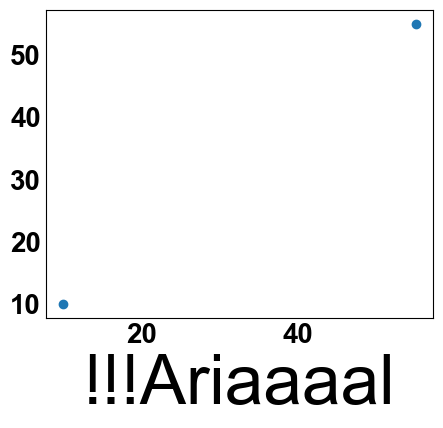

In [2]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [3]:
""" reading and preprocessing data"""
def read_csv_files(path):
    """
    Reads all CSV files in a given path and returns a concatenated Pandas DataFrame,
    where each CSV file is represented as a DataFrame.

    Args:
        path (str): Path to the directory containing the CSV files.

    Returns:
        pandas.DataFrame: A concatenated DataFrame representing the data in the CSV files.
    """
    dfs = []
    for file_name in os.listdir(path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(path, file_name)
            df = pd.read_csv(file_path)
            dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True)
    return concatenated_df

# Usage example
path = "./../data/trainingsets/60000_train_regular_pubqc"
csv_data = read_csv_files(path)
df0 = csv_data.drop_duplicates(subset='SMILES')

In [4]:
print ('num of samples: ', len(df0))
print (min(df0['HOMO-LUMO gap']))
print (max(df0['HOMO-LUMO gap']))

num of samples:  150453
0.558
277.02


In [5]:
df0.iloc[df0['HOMO-LUMO gap'].idxmin()]

PCCDB-ID                               61313
SMILES                     CCCCC/C=C/C(=O)OC
HOMO-LUMO gap                           6.21
MP                                     -6.32
Dipole moment                            1.7
HOMO energy                              NaN
LUMO energy                              NaN
Excitation energy (1)                    NaN
Oscillator strength (1)                  NaN
Excitation energy (2)                    NaN
Oscillator strength (2)                  NaN
Excitation energy (3)                    NaN
Oscillator strength (3)                  NaN
Excitation energy (4)                    NaN
Oscillator strength (4)                  NaN
Unnamed: 0                               NaN
PCQCPM6_ID                               NaN
Name: 22530, dtype: object

In [6]:
max(df0['HOMO-LUMO gap'])

277.02

In [7]:
def convert_to_canonical(smiles):
    mol = Chem.MolFromSmiles(smiles)  # Read the SMILES and create a RDKit molecule object
    if mol is not None:
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)  # Convert to canonical SMILES
        return canonical_smiles
    else:
        #print (smiles)
        return None

# Apply the function to the 'SMILES' column to get canonical SMILES
df0['Canonical_SMILES'] = df0['SMILES'].apply(convert_to_canonical)

df = df0.copy()
# Drop rows with invalid SMILES that could not be converted to canonical SMILES
df.dropna(subset=['Canonical_SMILES'], inplace=True)
df.dropna(subset=['HOMO-LUMO gap'], inplace=True)
# Drop repetitives
df = df.drop_duplicates(subset='Canonical_SMILES', keep='last')

In [8]:
print ('num of samples: ', len(df))
print (min(df['HOMO-LUMO gap']))
print (max(df['HOMO-LUMO gap']))

num of samples:  138321
0.558
13.796


In [9]:
#df0[df0['HOMO-LUMO gap'].isnull()]

In [10]:
#df0[df0['Canonical_SMILES'].isnull()]

In [11]:
#gap_extra = df0['HOMO-LUMO gap'][df0['Canonical_SMILES'].isnull()]
#sns.histplot(gap_extra [gap_extra<12])

In [12]:
gap = np.array (df['HOMO-LUMO gap']).ravel()
IQR = - np.quantile(gap, 0.25) + np.quantile(gap, 0.75)
lower_bound, upper_bound = np.quantile(gap, 0.25) - 1.5 * IQR, np.quantile(gap, 0.75) + 1.5 * IQR
idx = np.array (np.where((gap >= lower_bound) & (gap <= upper_bound))).ravel()
df_outrem = df.iloc[idx]

In [13]:
len(df_outrem['HOMO-LUMO gap'])

138320

In [14]:
np.std (df_outrem['HOMO-LUMO gap'])

1.9822046911587456

In [15]:
print ('num of samples: ', len(df_outrem))
print (min(df_outrem['HOMO-LUMO gap']))
print (max(df_outrem['HOMO-LUMO gap']))

num of samples:  138320
0.558
12.106


In [16]:
# remove any samples less than 1 eV
df_big1 = df_outrem.loc[df_outrem['HOMO-LUMO gap']>1]

In [17]:
print ('num of samples: ', len(df_big1))
print (min(df_big1['HOMO-LUMO gap']))
print (max(df_big1['HOMO-LUMO gap']))

num of samples:  138313
1.048
12.106


In [18]:
Canonical_SMILES_dot = []
for smiles in df_big1['Canonical_SMILES']:
    smiles += '.'
    Canonical_SMILES_dot.append(smiles)
    
df_big1 ['Canonical_SMILES_dot'] = Canonical_SMILES_dot
df_big1 = df_big1.reset_index(drop=True)
df_big1

,PCCDB-ID,SMILES,HOMO-LUMO gap,MP,Dipole moment,HOMO energy,LUMO energy,Excitation energy (1),Oscillator strength (1),Excitation energy (2),Oscillator strength (2),Excitation energy (3),Oscillator strength (3),Excitation energy (4),Oscillator strength (4),Unnamed: 0,PCQCPM6_ID,Canonical_SMILES,Canonical_SMILES_dot
0,190,Nc1nc[nH]c2c1ncn2,4.724,191.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nc1nc[nH]c2ncnc1-2,Nc1nc[nH]c2ncnc1-2.
1,309,OC(=O)C/C(=CC(=O)O)/C(=O)O,4.718,218.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C(O)C=C(CC(=O)O)C(=O)O,O=C(O)C=C(CC(=O)O)C(=O)O.
2,777,Cc1ncc(c(=N)[nH]1)CO,4.702,111.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ncc(CO)c(=N)[nH]1,Cc1ncc(CO)c(=N)[nH]1.
3,976,OC(=O)C(=O)CC=C,4.781,52.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=CCC(=O)C(=O)O,C=CCC(=O)C(=O)O.
4,1673,Nc1ncn(c2c1ncn2)C,4.757,147.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cn1cnc(N)c2ncnc1-2,Cn1cnc(N)c2ncnc1-2.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138308,10910783,Cc1cc(N)c2c(c1)c1ccccc1C2=O,3.641,154.71,2.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1cc(N)c2c(c1)-c1ccccc1C2=O,Cc1cc(N)c2c(c1)-c1ccccc1C2=O.
138309,10910901,C1=C[C]2SC=c3c2c2[C]1SC=c2cc3,3.676,136.01,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1=C[C]2SC=c3ccc4c(c32)[C]1SC=4,C1=C[C]2SC=c3ccc4c(c32)[C]1SC=4.
138310,10921461,[CH]CCCOC(=O)[C@H]1[C@H](C)CCC1=O,3.630,36.32,4.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[CH]CCCOC(=O)C1C(=O)CCC1C,[CH]CCCOC(=O)C1C(=O)CCC1C.
138311,10921654,N#CC1=C(CC)c2c3c1cccc3ccc2,3.663,127.76,5.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCC1=C(C#N)c2cccc3cccc1c23,CCC1=C(C#N)c2cccc3cccc1c23.


In [19]:
max = 40
index_larger40 = []
for e, smile in enumerate (df_big1 ['Canonical_SMILES_dot']):
    if len(smile)>max:
        index_larger40.append(e)
        print (smile)
        print (df_big1 ['PCCDB-ID'].iloc[e])

O=C(O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1.
7433
COC(=O)CCC([N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-].
22132
CC(=O)Oc1c(C)cc([N+](=O)[O-])cc1[N+](=O)[O-].
29079
O=C(O)c1c([N+](=O)[O-])cccc1[N+](=O)[O-].
119206
CC(C)(C)c1ccc(C(C)(C)C)c([N+](=O)[O-])c1.
137948
[NH]C1=N[C](C[C]2N=C([NH])NC(=N)N2)NC(=N)N1.
265616
COC(=O)c1cc2c(c([N+](=O)[O-])c1)C(C)(C)C2.
287227
O=[N+]([O-])c1ccc(OCC2CO2)c([N+](=O)[O-])c1.
319009
CC(=O)Oc1c([N+](=O)[O-])cc(C)cc1[N+](=O)[O-].
536894
Cc1nc2[nH]c(=N)[nH]n2c(=O)c1[N+](=O)[O-].
537534
CCOC(=O)c1ccc([N+](=O)[O-])cc1[N+](=O)[O-].
606827
[CH]1[CH][CH][C]2C=C[CH][CH][C]([CH]1)C2.
137603
C=C1[C]2[CH][CH][CH][CH][C]1[CH][CH][CH][CH]2.
139159
[CH]1C=C[CH]C2=C[C]3[CH]C=C[CH]C4=C[C]1C2CC34.
141245
[CH]1[CH][C]2C=C3[CH]C=CC=C4C=C(C=C1)C21CC341.
142320
[CH]1[C]2C=C[C]3CC[C]4C=C[C]([CH][C]4CC[C]13)CC2.
143532
[CH]1C=C[CH][C]2C[C]1C=CC1=CC=C[CH][C]2C1.
605787
[C]1[C][CH][CH][CH][CH][CH]C=C=[C][CH][CH]1.
5463468
[CH]1[CH]c2c([nH]c3c2C=CC[CH][CH]3)C=CC1.
10375412
CC12[C]3[CH]CC

In [20]:
len(index_larger40)

745

In [21]:
# Remove rows based on indices in the list
df_big1_40maxchar = df_big1.drop(index_larger40)
df_big1_40maxchar = df_big1_40maxchar.reset_index(drop=True)
df_big1_40maxchar

,PCCDB-ID,SMILES,HOMO-LUMO gap,MP,Dipole moment,HOMO energy,LUMO energy,Excitation energy (1),Oscillator strength (1),Excitation energy (2),Oscillator strength (2),Excitation energy (3),Oscillator strength (3),Excitation energy (4),Oscillator strength (4),Unnamed: 0,PCQCPM6_ID,Canonical_SMILES,Canonical_SMILES_dot
0,190,Nc1nc[nH]c2c1ncn2,4.724,191.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nc1nc[nH]c2ncnc1-2,Nc1nc[nH]c2ncnc1-2.
1,309,OC(=O)C/C(=CC(=O)O)/C(=O)O,4.718,218.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C(O)C=C(CC(=O)O)C(=O)O,O=C(O)C=C(CC(=O)O)C(=O)O.
2,777,Cc1ncc(c(=N)[nH]1)CO,4.702,111.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ncc(CO)c(=N)[nH]1,Cc1ncc(CO)c(=N)[nH]1.
3,976,OC(=O)C(=O)CC=C,4.781,52.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=CCC(=O)C(=O)O,C=CCC(=O)C(=O)O.
4,1673,Nc1ncn(c2c1ncn2)C,4.757,147.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cn1cnc(N)c2ncnc1-2,Cn1cnc(N)c2ncnc1-2.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137563,10910783,Cc1cc(N)c2c(c1)c1ccccc1C2=O,3.641,154.71,2.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1cc(N)c2c(c1)-c1ccccc1C2=O,Cc1cc(N)c2c(c1)-c1ccccc1C2=O.
137564,10910901,C1=C[C]2SC=c3c2c2[C]1SC=c2cc3,3.676,136.01,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1=C[C]2SC=c3ccc4c(c32)[C]1SC=4,C1=C[C]2SC=c3ccc4c(c32)[C]1SC=4.
137565,10921461,[CH]CCCOC(=O)[C@H]1[C@H](C)CCC1=O,3.630,36.32,4.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[CH]CCCOC(=O)C1C(=O)CCC1C,[CH]CCCOC(=O)C1C(=O)CCC1C.
137566,10921654,N#CC1=C(CC)c2c3c1cccc3ccc2,3.663,127.76,5.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCC1=C(C#N)c2cccc3cccc1c23,CCC1=C(C#N)c2cccc3cccc1c23.


In [22]:
len (df_big1_40maxchar) - len(df_big1)

-745

In [23]:
print (np.min (df_big1_40maxchar['HOMO-LUMO gap']))
print (np.max (df_big1_40maxchar['HOMO-LUMO gap']))

1.048
12.106


In [24]:
# use 0 and 11 to normalize the gaps, we then focus on [0-1]
# 1 is min. 
# 11 is max. 
df_big1less11_40maxchar = df_big1_40maxchar.loc[df_big1_40maxchar["HOMO-LUMO gap"] <= 11]
print (np.min (df_big1less11_40maxchar['HOMO-LUMO gap']))
print (np.max (df_big1less11_40maxchar['HOMO-LUMO gap']))

1.048
10.985


In [25]:
index_Si = []
for e, smile in enumerate (df_big1less11_40maxchar ['Canonical_SMILES_dot']):
    if 'Si' in smile:
        index_Si.append(e)
        print (smile)

C[Si](C)(C)c1cccc2ccccc12.
[SiH3]c1cccc2ccccc12.
Cc1ccc(-n2cc([Si](C)(C)C)nn2)s1.
CCC1=C(C)[Si](C)(C)C(C)=C1.
C[Si]1(c2cccc3ccccc23)CCC1.
C[Si](C)(C)c1ccc2ccccc2c1.
CC(=O)c1cccc(O[Si](C)(C)C)c1.
C1=CC[SiH]=C1.
[SiH2]c1ccc([SiH2])cc1.
C[SiH](C)c1ccc2cc3ccccc3cc2c1.
C[SiH](C)c1cccc2cc3ccccc3cc12.
C[SiH][SiH2].
C[SiH][SiH]C.
[SiH2][SiH]c1ccccc1.
[SiH2][C]1C=C1.
C1[SiH]2C[SiH]12.
C[SiH](C)N1C=CN([SiH](C)C)C=C1.
C[Si](C)(C)n1ccc2cc([N+](=O)[O-])ccc21.
C#Cc1ccc(C#C[Si](C)(C)C)s1.
C[Si](C)(C)n1ccnc1.
C[Si](C)(SCCN)SCCN.
C=CC[Si](C)(C)CC=C.
CC(C)(C)OO[Si](C)(C)C.
C[Si](C)(C)SCCS[Si](C)(C)C.
CO[Si](CS)(OC)OC.
CN(C)[SiH3].
C=C([Si](C)(C)C)[Si](C)(C)C.
C[Si](C)(CN)CN.
CC[Si](C)(C)n1ccnc1.
C=C[Si]1(C=C)CCCCC1.
C=CC[Si](CC=C)(OCC)OCC.
C[Si]1(C)CCCSC1.
CCCCN1CCCC[Si](C)(C)C1.
CC=C(CC)[Si](C)(C)C.
C[Si](C)(C)C1CCC2C3C=CC(C3)C21.
C=CC(C=C)O[Si](C)(C)C(C)(C)C.
C[Si](C)(C)C=CCCN=CO.
C[Si](C)(C)OC1CCOC1=O.
C[SiH](C)OOC(C)(C)C.
CCC(N)C(=O)O[Si](C)(C)C.
CC1=C(CO[Si](C)(C)C)CCCC1.
CC(C)=C1CC1[Si](C)(C)C.
C[

In [26]:
len (index_Si)

2845

In [27]:
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar.drop(index_Si)
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.reset_index(drop=True)

In [28]:
len(df_big1less11_40maxchar_noSi)-len(df_big1less11_40maxchar)

-2845

<Axes: xlabel='HOMO-LUMO gap', ylabel='Count'>

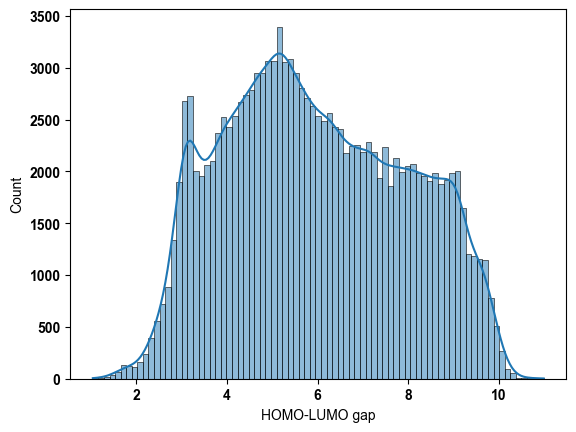

In [29]:
sns.histplot (df_big1less11_40maxchar_noSi['HOMO-LUMO gap'], kde=True)

In [30]:
index_Si = []
for e, smile in enumerate (df_big1less11_40maxchar_noSi ['Canonical_SMILES_dot']):
    if 'Si' in smile:
        index_Si.append(e)
        print (smile)

[SiH4].
C[Si](c1ccccc1)[Si](C)c1ccccc1.
CC(C)(C)[Si](C)(C)C(=S)c1ccccc1.
C[Si](C)(C)C#CC1=CC=C1.
C[Si](C)[Si]=O.
C[Si](C)(C)OC1C=CC=C2C=CC=CC=C21.
CC[C]1C=CC2=c3ccc(CC)cc3=[Si]C2=C1.
CC[C]1C=CC=C2C1=[Si]c1ccccc12.
CCO[Si]1(OCC)CCCO[Si]1.
C[Si]1(O)CCCO[Si]1.
CCCO[Si]1(OCCC)CCCO[Si]1.
C=[Si](O[Si][Si](C)(C)C)[Si](C)(C)C.
C1=C[C](c2ccccc2)[Si](c2ccccc2)C1.
C[Si](C)(C)OC1(O)C=CC2=C(C=C2)C1.
C[SiH](C)C.
CCCCC[Si](OCC)(OCC)OCC.
C[Si](C)(C)CCO.
C[SiH](C)O[SiH](C)C.
C[Si](C)(C)O[Si](C)(C)C.
O[Si](O)(O)O[Si](O)(O)O.
C[SiH](C)O[Si](C)(C)C.
C[Si](C)(C)CCCS([O])([O])O.
C[Si]1(C)CCC1.
C[Si](C)(C)OCCO[Si](C)(C)C.
C[Si](C)(C)OS(C)([O])[O].
CC1(C)CO[Si](C)(C)OC1.
CC[Si](OC(C)C)(OC(C)C)OC(C)C.
CC[Si](C)(C)O.
COC[Si](C)(C)C.
CO[Si](C)(C)O[Si](C)(C)OC.
CC(C)CCO[Si](C)(C)C.
CCCO[Si](OCC)(OCC)OCCC.
CCCO[Si](OC)(OC)OCCC.
CCO[Si](C)(C)C(C)(C)C.
CCCO[Si](C)(C)C(C)(C)C.
CCCO[Si]1(C)CCCC1.
CCCCO[Si]1(C)CCCC1.
C1CC[SiH2]C1.
CC1(C)CC[Si](C)(C)CC1.
CCCC(C)O[Si](C)(C)C.
CCCC(C)CO[Si](C)(C)C.
CCC(C)CO[Si](C)(C)C.
CC

In [31]:
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.drop(index_Si)
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.reset_index(drop=True)

In [32]:
index_si = []
for e, smile in enumerate (df_big1less11_40maxchar_noSi ['Canonical_SMILES_dot']):
    if 'si' in smile:
        index_si.append(e)
        print (smile)

c1c[siH]cc[siH]1.
C[si]1ccccc1.
c1cc[siH]cc1.


In [33]:
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.drop(index_si)
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.reset_index(drop=True)

In [34]:
index_6 = []
for e, smile in enumerate (df_big1less11_40maxchar_noSi ['Canonical_SMILES_dot']):
    if '6' in smile:
        index_6.append(e)
        print (smile)

C1C2CC3CCC45CCC6CC1[C]([C]2[C]34)[C]65.
C1=CC2C3C=CC4C5C=CC6C1C2C(C65)C34.
O=C1C2CC3C(=O)C4C5CC6C(C15)C2C3C64.
CC1(O)C2C3C4C5C(O)C6C4C2C2C6C5C3C21.
c1ccc(SC23C4C5C6C4C2C6C53)nc1.
C1CC2(C3(OC4(C56CCC5O6)CC4)CC3)OC12.
OC1=NC23C4C5C6C4C2(N1)C6C53.
c1cn(C23C4C5C6C4C2C6C53)cn1.


In [35]:
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.drop(index_6)
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.reset_index(drop=True)

In [36]:
index_5 = []
for e, smile in enumerate (df_big1less11_40maxchar_noSi ['Canonical_SMILES_dot']):
    if '5' in smile:
        index_5.append(e)
        print (smile)

c1ccc2c3c4c(ccc5cccc(c54)C3)cc2c1.
C1=Cc2cc3cccc4ccc5ccc(c2c5c43)C1.
c1c2c(cc3cc4cc5c(cc4cc13)CC5)CC2.
c1cc2ccc3ccc4c5c(cc(c1)c2c35)C4.
C1=Cc2c(cc3ccc4cccc5ccc2c3c45)C1.
C1=Cc2cc3ccc4cccc5ccc(c2C1)c3c45.
C1=Cc2ccc3ccc4cccc5cc(c2c3c45)C1.
C1=CC2=CC=c3ccc4cccc5c4c3C2C(=C1)C=5.
C1=Cc2cc3ccc4c5c(ccc(c2=C1)c35)CC=C4.
C1=Cc2c3c4c(ccc5cccc(c2=C1)c54)C=CC3.
c1cc2c3c(c4cccc5c4c(c3c1)CC5)CC2.
c1cc2c3c4c5c(cccc5cc3c1)CC4C2.
OC(=NC1CC1)C1C2C3C4CC5C3C5C4C12.
ON=C1C2C3CC4C5C3C1C5C1(OCCO1)C42.
CNC1C2C3CC4C5C3CC2C5C41.
O=C1C2C3CC4C5CC(C1C53)C42.
NC12CC3C4CC5C(CC1C35)C42.
OC12CC3C4C5C3C1C5C42.
C1CC2CC3CC4C5CC1C5C234.
CC12CC3C4CC5CC3C(O)(C1)C(C5)C4(O)C2.
C1CC12C1C3C4C5C1C5C2C43.
CC12C3C4C5C3C1C5C42.
NC1C2C3CC4C5CC(C42)C1(c1ccccc1)C53.
Cc1ccc2ccc3ccc4cccc5c4c3c2c1-5.
c1cc2noc3c4cccc5noc(c(c1)c23)c54.
OC12CC3C4CC5C(CC1C35)C42.
CCC12C3C4C5C3C1C5C42.
[N][N][C]1C2CC3C4CC5CC3C1C(C5)C4C2.
C1OC2OC3OC4OCC5C1C2C3C45.
C1CC2(C3C4CC5CC(C4)CC3C5)CCC1C2.
C1CC2C(C1)C1C3C4CC5C3C2N2C5C4N12.
[CH]1N=C[N]N1C12C3C4C5C3C1C5C4

In [37]:
index_p = []
for e, smile in enumerate (df_big1less11_40maxchar_noSi ['Canonical_SMILES_dot']):
    if 'P' in smile:
        index_p.append(e)
        print (smile)

O=[N+]([O-])c1ccc(OP2(=O)C=CCC2)cc1.
O=P1(O)c2ccccc2Nc2ccccc21.
O=P(O)(O)C(O)c1ccc2ccccc2c1.
O=C(O)C=C(OP(=O)(O)O)C(=O)O.
C[PH](C)(C)[CH]c1ccccc1.
CP(C)(=O)Oc1cccc([N+](=O)[O-])c1.
COP(=O)(OC)C(=O)c1ccccc1.
O=P1(O)c2ccccc2-c2ccccc21.
Cc1cc([N+](=O)[O-])ccc1P(=O)(O)O.
Cc1ccc([N+](=O)[O-])c(P(=O)(O)O)c1.
CP1(=O)CCC2=C1CCc1cc(O)ccc12.
CP1(=O)CCc2c1ccc1ccccc21.
O=P1(c2ccccc2)Nc2cccnc2N1.
O=P(O)(O)c1ccc2ccccc2n1.
C=C[PH]([S])(S)C=C.
N[PH]([S])(c1ccccc1)c1ccccc1.
[CH]1P[CH]c2ccccc21.
CCC1=CC=C[CH][CH][CH][CH]P1.
C=CC1=CC=C[CH][CH][CH][CH]P1.
[CH]1[CH][CH][CH][CH]P[CH][CH][CH]1.
CCCC(=O)C(=O)COP(=O)(O)O.
O=CC(=O)COP(=O)(O)O.
O=C(O)P(=O)(O)O.
CN(C)P(N(C)C)N(C)C.
CC(=O)OP1(=O)OCC(C)(C)CC1(C)O.
O=P1(O)C=CCC1.
C#CCSP(=O)(OCC)OCC.
CC1=CP(=O)(O)CC1.
CC(C)C[PH]([S])(CC(C)C)CC(C)C.
O=C(O)CC(C(=O)O)P(=O)(O)O.
NCCCSP(=O)(O)O.
C=CCP(=O)(CC=C)OCC.
C1N2CN3CN1CP(C2)C3.
NCCCNCCO[PH](O)(O)[S].
CC(C)P(N1CC1)N1CC1.
N[PH](O)(O)[S].
O=P(O)(O)CC(O)CC1=N[CH]N[N]1.
CCN(CC)P(=O)(SC)N(C)C.
CN(C)P(=O)(N(C)C)S(C)(=O)=O

In [38]:
print (len(index_p))

2977


In [39]:
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.drop(index_5)
df_big1less11_40maxchar_noSi = df_big1less11_40maxchar_noSi.reset_index(drop=True)

In [40]:
print (df_big1less11_40maxchar_noSi.shape)

(132626, 19)


In [41]:
# write the data in .pickle file
"""
with open('./../data/trainingsets/60000_train_regular_pubqc/database_SMILES.pickle', 'wb') as f:
    pickle.dump((df_big1less11_40maxchar_noSi['Canonical_SMILES_dot'], 
                 df_big1less11_40maxchar_noSi['HOMO-LUMO gap']), f)
"""


"\nwith open('./../data/trainingsets/60000_train_regular_pubqc/database_SMILES.pickle', 'wb') as f:\n    pickle.dump((df_big1less11_40maxchar_noSi['Canonical_SMILES_dot'], \n                 df_big1less11_40maxchar_noSi['HOMO-LUMO gap']), f)\n"

In [44]:

# read SMILES and gaps from .pickle file
with open('./../data/trainingsets/60000_train_regular_pubqc/database_SMILES.pickle', 'rb') as f:
    SMILES, gaps = pickle.load(f)


In [45]:
MAX_NB_WORDS = 27
MAX_SEQUENCE_LENGTH = 40

tokenizer_ = Tokenizer(num_words = MAX_NB_WORDS, 
                      char_level = True,
                      filters = '', 
                      lower = False)
tokenizer_.fit_on_texts(SMILES)

X_smiles = tokenizer_.texts_to_sequences(SMILES)
X_smiles = pad_sequences(X_smiles, 
                         maxlen = MAX_SEQUENCE_LENGTH,
                         padding = 'post')

X_smiles = to_categorical(X_smiles)

"""
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer_.index_word, f)

with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer_object.pickle', 'wb') as f:
    pickle.dump(tokenizer_, f)
"""
"""
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '
"""
SHAPE = list(X_smiles.shape) + [1]
X_smiles = X_smiles.reshape(SHAPE)

y = np.asarray(gaps).reshape([-1])

In [ ]:
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [ ]:
tokenizer_.texts_to_sequences

<bound method Tokenizer.texts_to_sequences of <keras.preprocessing.text.Tokenizer object at 0x7f769c85d550>>

In [ ]:
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '
tokenizer

{1: 'C',
 2: 'c',
 3: '(',
 4: ')',
 5: '1',
 6: 'O',
 7: '=',
 8: '.',
 9: 'N',
 10: '2',
 11: '[',
 12: ']',
 13: 'n',
 14: '3',
 15: 'H',
 16: 'S',
 17: '-',
 18: '#',
 19: '+',
 20: 's',
 21: 'o',
 22: 'P',
 23: 'F',
 24: '4',
 25: 'l',
 26: 'p',
 0: ' '}

In [46]:
print (SMILES[0])
print ((X_smiles[0]).shape)

Nc1nc[nH]c2ncnc1-2.
(40, 27, 1)


In [47]:
SMILES = np.asarray(SMILES)
# TRAIN/VAL split
idx = np.random.choice(len(y), int(len(y) * 0.2), replace = False)
train_idx = np.setdiff1d(np.arange(len(y)), idx)

X_smiles_test, SMILES_test, y_test = X_smiles[idx], SMILES[idx], y[idx]
X_smiles_train, SMILES_train, y_train = X_smiles[train_idx], SMILES[train_idx], y[train_idx]

####
"""
idx = np.where(y_train > 40)[0]
X_smiles_train, X_atoms_train, X_bonds_train, y_train = (X_smiles_train[idx],
                                                X_atoms_train[idx],
                                                X_bonds_train[idx],
                                                y_train[idx])


idx = np.where(y_test > 40)[0]
X_smiles_test, X_atoms_test, X_bonds_test, y_test = (X_smiles_test[idx],
                                                     X_atoms_test[idx],
                                                     X_bonds_test[idx],
                                                     y_test[idx])

"""

print (len(y_train))
print (len(y_test))

# whole dataset
with open('./../data/trainingsets//image.pickle', 'wb') as f:
    pickle.dump((X_smiles, SMILES, y), f)

"""
with open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'wb') as f:
    pickle.dump((X_smiles_train, SMILES_train, y_train), f)

with open('./../data/trainingsets//image_test.pickle', 'wb') as f:
    pickle.dump((X_smiles_test, SMILES_test, y_test), f)
"""



106101
26525


"\nwith open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'wb') as f:\n    pickle.dump((X_smiles_train, SMILES_train, y_train), f)\n\nwith open('./../data/trainingsets//image_test.pickle', 'wb') as f:\n    pickle.dump((X_smiles_test, SMILES_test, y_test), f)\n"

In [48]:
X_smiles.shape

(132626, 40, 27, 1)

In [ ]:
106101+26525

132626

<Axes: ylabel='Percent'>

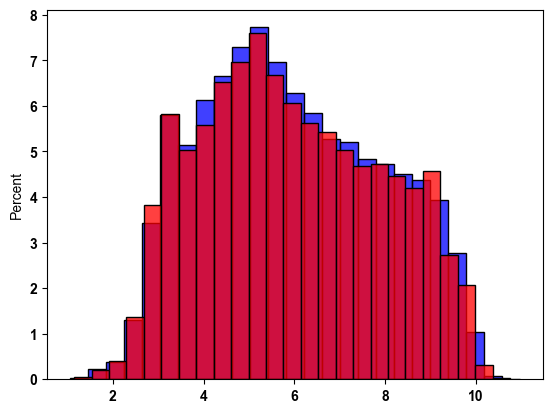

In [ ]:
plt.close()
sns.histplot(y_train, stat='percent', color='blue', bins=25)
sns.histplot(y_test, stat='percent', color='red', bins=25)